In [ ]:
# Mount notebook to google drive:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Install Pytorch-Lightning, PyTorch Geometric and other packages:

!pip install pytorch_lightning

#TORCH = 1.11.0
#CUDA = cu113

!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
!pip install torch-geometric

In [ ]:
# Import NetworkX

import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
# PyTorch
import pytorch_lightning as pl
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric.nn as geom_nn


Let’s take a minute and look at how one can create graphs using NetworkX. NetworkX is a Python package that can be used for creating graphs. Here is how you can use the package to create an empty graph with no nodes. 

In [ ]:
G = nx.Graph()

# You can then add some nodes to the graph using the `add_nodes` function. 
G.add_nodes_from([2, 3])

# Next, add some edges to the graph using the `add_edges_from` function. 
edges = [(2,1),(2,2),(3,2),(4,3),(6,4),(7,5),(14,5)]
G.add_edges_from(edges)

# The graph can be visualized using Matplotlib. That is done by calling the `draw` function and using Matpotlib to show the graph.
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

In [ ]:
# Do the same for simple graph in GNN_tutorial:
G = nx.Graph()
G.add_nodes_from([1, 2, 3, 4]) 

E = [(1 , 2), (2 ,3), (2, 4), (3, 4)]
G.add_edges_from(E)

nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

In [ ]:
# Create values for each node and store them in node_values:

node_coords = Tensor([[1., 2., 3.],
                      [2., 4., 6.],
                      [0., 0., 1.],
                      [1., 0., 0.]])

node_colors = ["blue", "green", "red", "yellow"]


print(node_coords.shape)
print(node_coords[0])
print(len(node_colors))
print(node_colors[0])

In [ ]:
# This time add atributes in Graph's nodes:

Gv = nx.Graph()

for i in range(4):
  Gv.add_node(i, vertex = str(node_coords[i]), color = node_colors[i])

Ev = [(1 , 2), (2 ,3), (2, 4), (3, 4)]
Gv.add_edges_from(Ev)

#nx.draw(Gv, with_labels=True, font_weight='bold')
#plt.show()

print(Gv.nodes[0]["vertex"], Gv.nodes[1]["vertex"], Gv.nodes[2]["vertex"], Gv.nodes[3]["vertex"])
print(Gv.nodes[1]["color"])

In [ ]:
# Create two different Graphs and store them in a list:

G1 = Gv

G2 = nx.Graph()
G2.add_nodes_from([1, 2, 3, 4, 5])
E2 = [(1 ,2), (1, 3), (2, 3), (2, 4), (2, 5), (4, 5)] 
G2.add_edges_from(E2)

#nx.draw(G1, with_labels=True, font_weight='bold')
#plt.show()
#nx.draw(G2, with_labels=True, font_weight='bold')
#plt.show()

G_inp_list = [G1, G2]

print(len(G_inp_list))
print(G_inp_list[0])
print(G_inp_list[1])

Data(x=[4, 3], edge_index=[2, 4], y=[4])


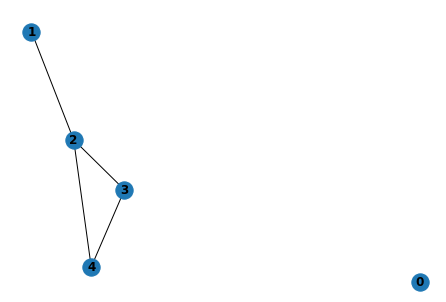

In [ ]:
# Create example with edges_list in COO Format:

# Node attributes:
x = torch.tensor([[1., 2., 3.],
                  [2., 4., 6.],
                  [0., 0., 1.],
                  [1., 0., 0.]], dtype=torch.float)

# Node labels:
y = torch.tensor([10, 11, 12, 13], dtype = torch.float)


# Edge index in COO format:
# 1st list contains source/origin node
# 2nd list contains target/destination node
edge_index = torch.tensor([[1, 2, 2, 3],
                           [2, 3, 4, 4]], dtype=torch.long)



# Graph in pytorch_geometric format and 
# visualization after converting it to networkx format:

from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

Graph = Data(edge_index=edge_index, x=x, y=y)
print(Graph)

g = to_networkx(Graph, to_undirected=True)
nx.draw(g, with_labels=True, font_weight='bold')
plt.show()

Create a simple Graph GNN model to visualize the input dimension etc:

In [ ]:
gnn_layer_by_name = {"GCN": geom_nn.GCNConv, "GAT": geom_nn.GATConv, "GraphConv": geom_nn.GraphConv}

In [ ]:
class GNNModel(nn.Module):
    def __init__(
        self,
        c_in,
        c_hidden,
        c_out,
        num_layers=2,
        layer_name="GCN",
        dp_rate=0.1,
        **kwargs,
    ):
        """
        Args:
            c_in: Dimension of input features
            c_hidden: Dimension of hidden features
            c_out: Dimension of the output features. Usually number of classes in classification
            num_layers: Number of "hidden" graph layers
            layer_name: String of the graph layer to use
            dp_rate: Dropout rate to apply throughout the network
            kwargs: Additional arguments for the graph layer (e.g. number of heads for GAT)
        """
        super().__init__()
        gnn_layer = gnn_layer_by_name[layer_name]

        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers - 1):
            layers += [
                gnn_layer(in_channels=in_channels, out_channels=out_channels, **kwargs),
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate),
            ]
            in_channels = c_hidden
        layers += [gnn_layer(in_channels=in_channels, out_channels=c_out, **kwargs)]
        self.layers = nn.ModuleList(layers)

    def forward(self, x, edge_index):
        """
        Args:
            x: Input features per node
            edge_index: List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
        """
        for layer in self.layers:
            # For graph layers, we need to add the "edge_index" tensor as additional input
            # All PyTorch Geometric graph layer inherit the class "MessagePassing", hence
            # we can simply check the class type.
            if isinstance(layer, geom_nn.MessagePassing):
                x = layer(x, edge_index)
            else:
                x = layer(x)
        return x

In [ ]:
import torch
from torch_geometric.data import Data
## Create an undirected graph having three nodes (0, 1, 2).
## Nodes 0 and 1 are connected; nodes 1 and 2 are connected (in both directions).
## Each node has a single feature. These features are equal to
## -1, 0, 1 for the three nodes respectively, in this order.
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

G1 = Data(x=x, edge_index=edge_index)

In [ ]:
# Atom types, ordered accroding to one-hot-encoding
import pandas as pd

MUT_LABEL_ENC = pd.Series(data = ["C","O", "Cl","H","N","F","Br","S","P","I","Na","K","Li","Ca"])
print("Number of different elements: ", len(MUT_LABEL_ENC))

# Define transform
class AddSymbols(object):
    """
    Add the symbol of the elements, from the atomic number, as a key of the graph
    """
    def __call__(self, graph):
        graph.symbols = MUT_LABEL_ENC.loc[graph.x.argmax(dim=-1)].values
       
        return graph

Number of different elements:  14


In [ ]:
from torch_geometric.datasets import TUDataset

# Load the dataset
dataset = TUDataset(
    root=".", name="Mutagenicity",
    transform=AddSymbols(),
).shuffle()

Extracting ./Mutagenicity/Mutagenicity.zip
Processing...
Done!


In [ ]:
import numpy as np

print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Samples per class: {[ np.sum([1 for graph in dataset if graph.y == i ]) for i in range(dataset.num_classes) ]}')

all_atoms = np.concatenate(
    [graph.symbols for graph in dataset]
)
print(f"{len(np.unique(all_atoms))} unique atoms: {np.unique(all_atoms)}")

Dataset: Mutagenicity(4337):
Number of graphs: 4337
Number of features: 14
Number of classes: 2
Samples per class: [2401, 1936]
14 unique atoms: ['Br' 'C' 'Ca' 'Cl' 'F' 'H' 'I' 'K' 'Li' 'N' 'Na' 'O' 'P' 'S']


In [ ]:
G = dataset[0]  # Get the first graph object.
print(G)
# Gather some statistics about the first graph.
print(f'Number of nodes: {G.num_nodes}')
print(f'Number of edges: {G.num_edges}')
print(f'Average node degree: {G.num_edges / G.num_nodes:.2f}')
print(f'Contains isolated nodes: {G.has_isolated_nodes()}')
print(f'Contains self-loops: {G.has_self_loops()}')
print(f'Is undirected: {G.is_undirected()}')

Data(edge_index=[2, 24], x=[13, 14], edge_attr=[24, 3], y=[1], symbols=[13])
Number of nodes: 13
Number of edges: 24
Average node degree: 1.85
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


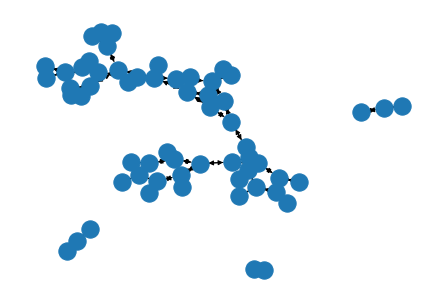

In [ ]:
G = dataset[2]
G_nx = to_networkx(G)
nx.draw(G_nx)
plt.show()